# Image colorization network

In this lab we will train an image colorization network. Image generation/translation is more memory and computation consuming task than image classification and is also harder to train. That is why, while is it still possible to run the training for the current assignment on CPU, we recommend to use GPU (if available) or Google Colab.
In the latter case, you will find comments with additional commands to run.


## Overview
We will train Unet-style CNN with a content loss on ImageNette dataset, which we have already used in the previous assignment. Now we will go over the functions, classes, models you need to implement and train.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import kornia as K
import torchvision.transforms as tfms
from tqdm import tqdm_notebook as twdm
from time import time

def imshow_torch(tensor,figsize=(8,6), *kwargs):
    plt.figure(figsize=figsize)
    plt.imshow(K.tensor_to_image(tensor), *kwargs)
    return

def imshow_torch_channels(tensor, dim = 1, *kwargs):
    num_ch = tensor.size(dim)
    fig=plt.figure(figsize=(num_ch*5,5))
    tensor_splitted = torch.split(tensor, 1, dim=dim)
    for i in range(num_ch):
        fig.add_subplot(1, num_ch, i+1)
        plt.imshow(K.tensor_to_image(tensor_splitted[i].squeeze(dim)), *kwargs)
    return

mean, std = [0.46248055, 0.4579692, 0.42981696], [0.14145005, 0.1439656, 0.1707164]

train_transform = tfms.Compose([tfms.Resize((128,128)),
                                tfms.RandomHorizontalFlip(),
                                tfms.ToTensor(),
                                tfms.Normalize(mean, std)])

val_transform = tfms.Compose([tfms.Resize((128,128)),
                                tfms.ToTensor(),
                              tfms.Normalize(mean, std)])

# Data loader

We don't need labels, but we need two version of the image to train: decolorized as an input and original as target.

It can be simply implemended as following


In [3]:
class DecolorImagesDataset(tv.datasets.ImageFolder):
    def __getitem__(self, idx):
        item = super(DecolorImagesDataset, self).__getitem__(idx)
        out = K.color.rgb_to_grayscale(item[0]).expand(3, -1, -1), item[0]
        return out

In [4]:
# Taken from here https://stackoverflow.com/a/58748125/1983544
num_workers = os.cpu_count()
if 'sched_getaffinity' in dir(os):
    num_workers = len(os.sched_getaffinity(0))
print (f"Num workers = {num_workers}")

ImageNette_train = DecolorImagesDataset('imagenette2-160/train',
                                          transform = train_transform)    
ImageNette_val = DecolorImagesDataset('imagenette2-160/val', 
                                    transform = val_transform)

BS = 6 
train_dl = torch.utils.data.DataLoader(ImageNette_train,
                                       batch_size= BS,
                                       shuffle = True, # important thing to do for training. 
                                       num_workers = num_workers)
val_dl = torch.utils.data.DataLoader(ImageNette_val,
                                     batch_size= 2,
                                     shuffle = False,
                                     num_workers = num_workers,
                                     drop_last=False) 

Num workers = 8


## Unet 
[Unet](https://arxiv.org/abs/1505.04597) is one of the most popular and well-performing architectures for image translation (segmentation, colorization, restoration, etc.) tasks. It consists of image encoder, similar to the image classification task, and a decoder, which gradually increases spatial resolution back to the original one. In addition, all blocks from the decoder are skip-connected to their same-resolution counterparts from the encoder. 

![image.png](training-colorization-GAN_files/att_00000.png)

There are many ways of implementing Unet, Unet can be done based on any backbone architecture: [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), [VGGNet](https://arxiv.org/pdf/1409.1556), [ResNet](https://arxiv.org/abs/1512.03385), etc.

We will be using a trick from fast.ai and Deoldify by Jason Antic, (Deoldify), Jeremy Howard (fast.ai), and Uri Manor (Salk Institute): [using ImageNet-pretrained network for implementing Unet encoder part](https://www.fast.ai/2019/05/03/decrappify/). This saves a lot of training time compared to training from scratch. 

Your task is to implement class `UnetFromPretrained`.

Here we write some code snippets, which might help with implementation.


### How to get pretrained model from [torchvision](https://pytorch.org/docs/stable/torchvision/models.html)

To get pretrained model, pass `True` to the constructor

In [5]:
vgg13_bn = tv.models.vgg13_bn(True)
print (vgg13_bn)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

You can pick specific layers from sequential models. For example, to get indexes of layers, where downscaling is happens, try the following:

In [6]:
downscale_idxs = []
for i, l in enumerate(vgg13_bn.features):
    try:
        stride = l.stride
    except:
        stride = 1
    if type(stride) is tuple:
        stride = stride[0]
    if stride > 1:
        print (i, l)
        downscale_idxs.append(i)

6 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
13 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
20 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
27 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
34 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


 To create a block from the part of the model, you can use the following:
 

In [7]:
st_idx = 3
fin_idx = 8
module = nn.Sequential(*vgg13_bn.features[st_idx:fin_idx])
print (module)

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


We recommend to use `kornia.PyrDown()` for downscaling and `F.interpolate(***, mode='bilinear', align_corners = False)` for upscaling. MaxPooling leads to information loss for the backprop and strided convolution lead to artifacts. For detailed reference why PyrDown downscaling is better and more advanced variants see [The Devil is in the Decoder: Classification, Regression and GANs](https://arxiv.org/abs/1707.05847).


I also recommend to check this interactive paper/post about checkerboard artifacts in image generation:
[Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)

If you use normalization in the decoder, it is safer to use [GroupNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.GroupNorm), `nn.GroupNorm` instead of BatchNorm because of small batch size.

**Don't hardcode the structure from the reference example: you would need to implement the code to generate it AND use ImageNet-pretrained weights**

In [8]:
from colorization import UnetFromPretrained
unet = UnetFromPretrained(vgg13_bn.features)
print (unet)

UnetFromPretrained(
  (down_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): PyrDown()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): PyrDown()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_siz

## Perceptual loss

As loss we will be using so called perceptual loss. Below is the Figure from  [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) by Justin Johnson, Alexandre Alahi, and Li Fei-Fei, ECCV 2016, where it was proposed at first.
![image.png](training-colorization-GAN_files/att_00001.png)

It is a simple mean square error (MSE) loss between generated image and target image, but not on the pixel level, but instead on some feature map of the ImageNet pretrained network. Compared to MSE-pixel loss it tends to produce less blurry images, compared to L1 loss - better to capture semantics and small image misalignments. 

It is also used as a first part of [NoGAN training](https://www.fast.ai/2019/05/03/decrappify/) by Deoldify by Jason Antic, (Deoldify), Jeremy Howard (fast.ai), and Uri Manor (Salk Institute). Also it was proposed in "[Learning Implicit Generative Models by Matching Perceptual Features](http://openaccess.thecvf.com/content_ICCV_2019/papers/dos_Santos_Learning_Implicit_Generative_Models_by_Matching_Perceptual_Features_ICCV_2019_paper.pdf)" by Cicero Nogueira dos Santos, Youssef Mroueh, Inkit Padhi, Pierre Dognin. which inspired the current assignment. 

Implement `class ContentLoss(nn.Module)`, which takes pretrained architecture network name and `layer_id` and an input and creates such a network during initialization. During `forward` it should do forward pass of input image and target image through this network and calculate `F.mse_loss` between them. Hint: to save time and memory, you can use `with torch.no_grad():` for getting the features of the target (**but not the generated**) image

In [9]:
from cnn_training import weight_init
from colorization import UnetFromPretrained,ContentLoss

generator = UnetFromPretrained(vgg13_bn.features)
model = generator
model.up_blocks.apply(weight_init)
model.final.apply(weight_init)
loss_fn_content = ContentLoss('alexnet', 11)

In [10]:
from cnn_training import lr_find
losses, lrs = lr_find(model.cpu(), train_dl, loss_fn_content)

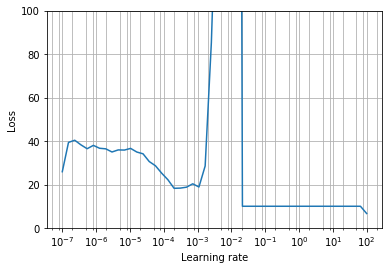

In [11]:
# https://stackoverflow.com/questions/44078409/matplotlib-semi-log-plot-minor-tick-marks-are-gone-when-range-is-large/44079725#44079725
def plot_lrs_losses(lrs, losses):
    import matplotlib.ticker
    fig, ax=plt.subplots()
    ax.semilogx(lrs, losses)
    ax.set_ylim([0, 100.])
    ax.grid(True, which="both")
    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
    ax.xaxis.set_major_locator(locmaj)
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.5, 0.8),numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    plt.show()
    return
plot_lrs_losses(lrs, losses)

In [ ]:
#If you work in Google Colab - uncomment and run the following
#%load_ext tensorboard
#%tensorboard --logdir runs

# Training

As we are training only decoder part, then don't forget to pass into optimizer only decoder part of the network (see in example below)

In [ ]:
from cnn_training import train_and_val_single_epoch
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(comment="ContentLoss_Color_AdamW_no_scheduler_Residual") #Comment is a name for graph (see screenshot below)
opt = torch.optim.AdamW(list(model.up_blocks.parameters())+
                        list(model.final.parameters()),lr=1e-4, weight_decay=1e-4, eps=1e-2)
for ep in range(10):
    t=time()
    model = train_and_val_single_epoch(model, train_dl, val_dl, opt, loss_fn_content, ep, writer=writer,
                                      device=torch.device('cuda'))
    el = time() -t
    print (f"Train epoch in {el:.1f} sec")

In [12]:
# Lets save our model
#torch.save(model.state_dict(), 'colorization_model.pt')
#model.load_state_dict(torch.load('coloriz_from_vgg13bn.pt'))


<All keys matched successfully>

# Visual check

Lets check visually, how our network is doing on valiadation set

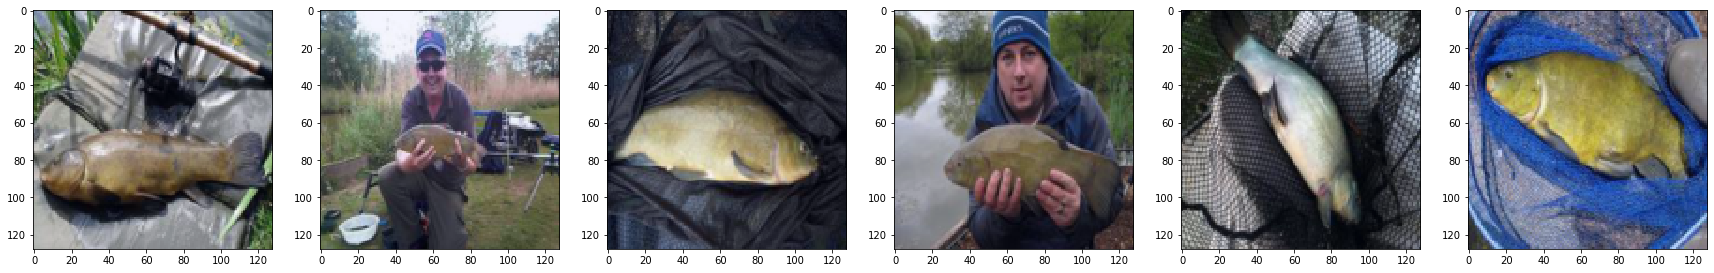

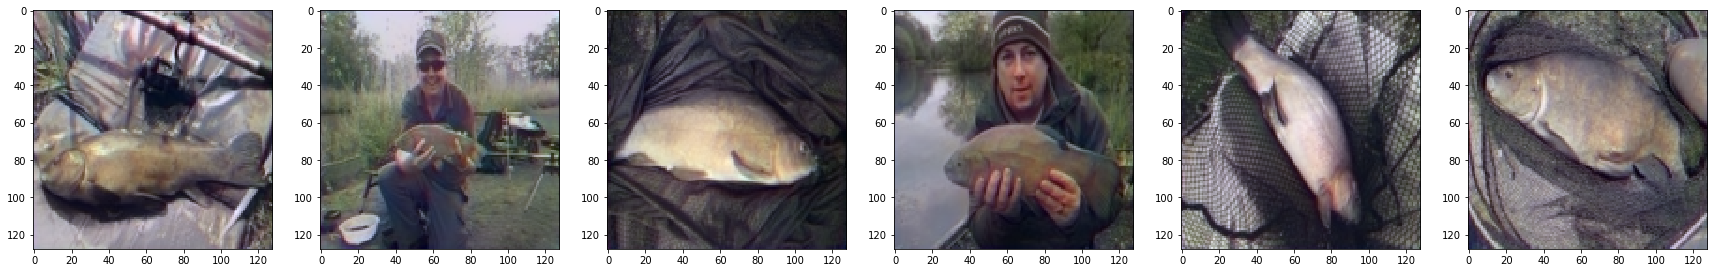

In [22]:
def normalize_and_quantize(timg):
    out1 = (timg.cpu()+torch.tensor(mean).view(1,3,1,1))*torch.tensor(std).view(1,3,1,1)
    out2 = 255*(out1-out1.min()) / (out1.max() - out1.min())
    return out2.byte()

model.eval()
model = model.cpu()
color_orig_normalized = []
color_predicted_normalized = []
count = 0
for gray, color in val_dl:
    with torch.no_grad():
        colorized = model(gray)
    color_orig_normalized += [normalize_and_quantize(x.unsqueeze(0)) for x in color]
    color_predicted_normalized += [normalize_and_quantize(x.unsqueeze(0)) for x in colorized]
    count+=1
    if count >=3:
        break

imshow_torch_channels(torch.cat(color_orig_normalized,dim=0),0)
imshow_torch_channels(torch.cat(color_predicted_normalized,dim=0),0)

In [23]:
# Finally, lets try on images from different dataset

In [11]:
from cnn_training import TestFolderDataset
class DecolorImagesDatasetTest(TestFolderDataset):
    def __getitem__(self, idx):
        item = super(DecolorImagesDatasetTest, self).__getitem__(idx)
        return K.color.rgb_to_grayscale(item).expand(3, -1, -1), item
            
test_transform = tfms.Compose([#tfms.Resize((128,128)),
                        tfms.ToTensor(),
                        tfms.Normalize(mean, std)])
    
test_data = DecolorImagesDatasetTest('to_colorize',
                              transform=test_transform)

test_dl = torch.utils.data.DataLoader(test_data,
                                      batch_size= 1,
                                     shuffle = False,
                                     num_workers = 1,
                                     drop_last=False)


In [ ]:
model.eval()
model = model.cpu()
count = 0
to_show = []
for gray, color in test_dl:
    with torch.no_grad():
        colorized = model(gray)
        quantized = normalize_and_quantize(colorized)
        fname = f'out_{count}.png'
        cv2.imwrite(fname, cv2.cvtColor(K.tensor_to_image(quantized), cv2.COLOR_RGB2BGR))
        count+=1

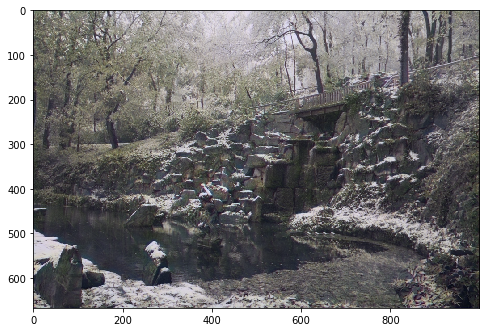

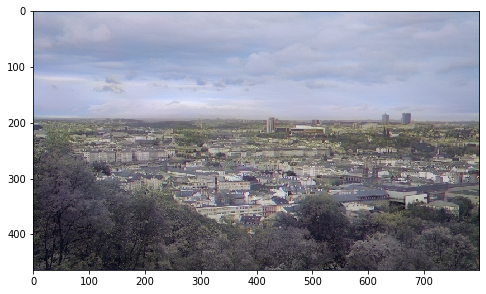

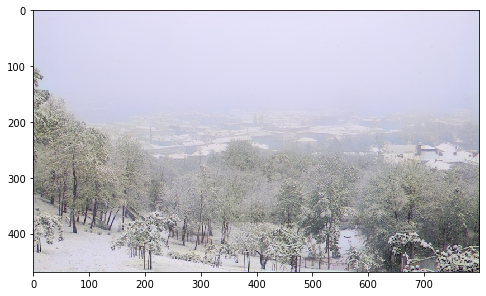

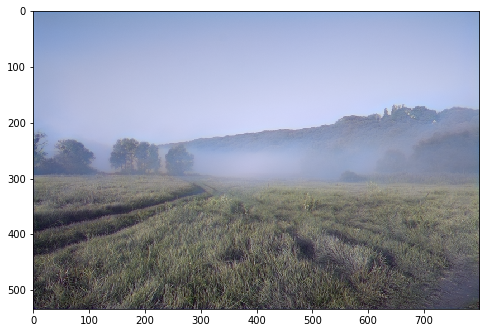

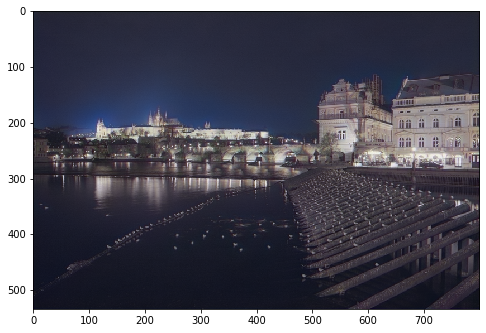

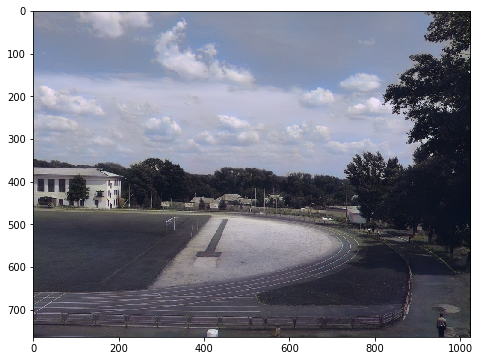

In [19]:
for c in range(count):
    fname = f'out_{c}.png'
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(img)